<a href="https://colab.research.google.com/github/G-Gaddu/Quant-Material/blob/main/Quantum_Portfolio_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using quantum computational methods to solve the Markowitz optimisation problem on Bond ETFs

In [202]:
# Import the packages
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from qiskit_finance.data_providers import *
from qiskit_algorithms.utils import algorithm_globals

In [203]:
# Define the Universe, here we will look at Bond ETFs
bond_etfs = [
    'TLT', 'IEF', 'LQD', 'AGG', 'BND', 'HYG', 'SHY', 'TIP', 'BIV', 'BNDX',
    'EMB', 'BSV', 'MUB', 'VCSH', 'VCIT', 'VCLT', 'VGLT', 'VGIT', 'VTEB',
    'SRLN', 'ICSH']

In [208]:
# Load the data
data = YahooDataProvider(tickers=bond_etfs,start=datetime.datetime(2024, 6, 26),end=datetime.datetime(2024, 9, 26),)
data.run()

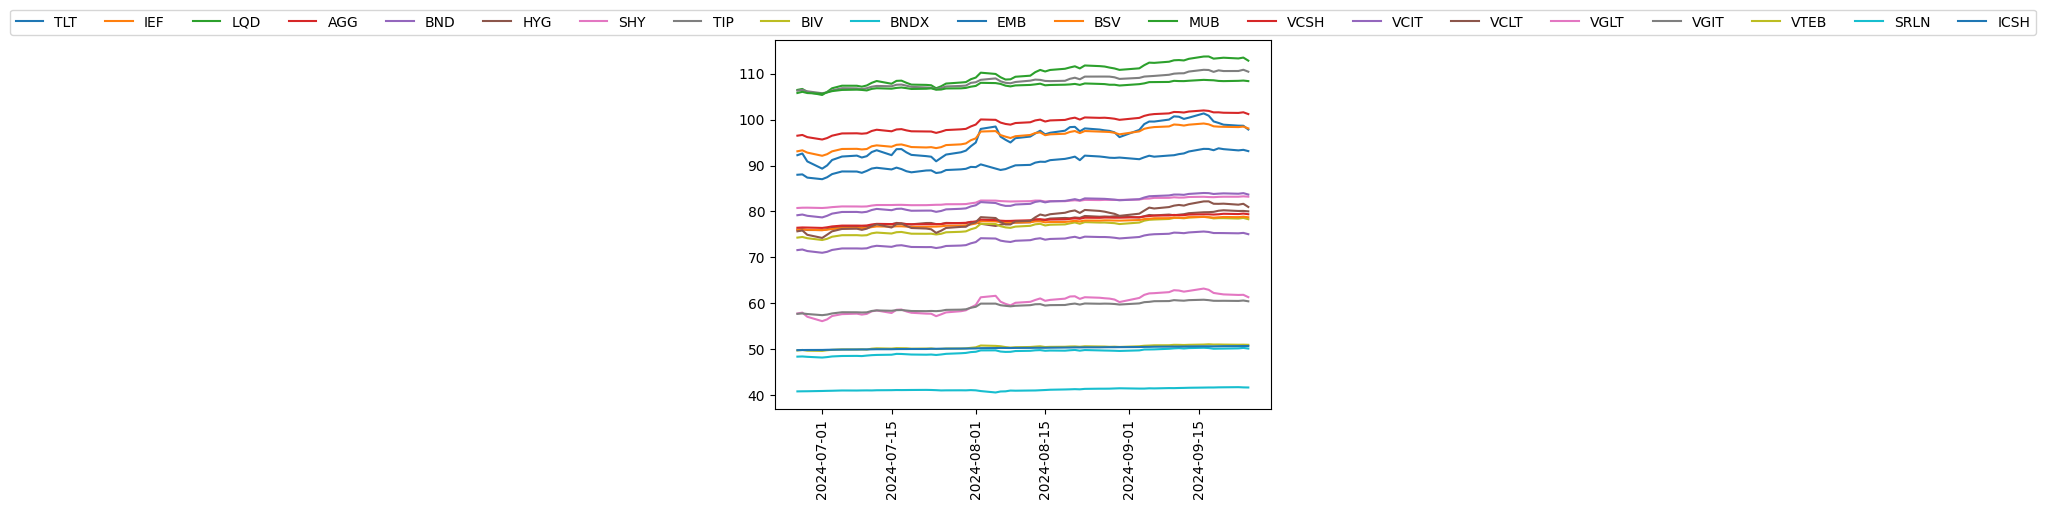

In [209]:
# Plot the data
for (cnt, s) in enumerate(data._tickers):
  plt.plot(data._data[cnt], label=s)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=len(bond_etfs))
plt.xticks(rotation=90)
plt.show()

In [210]:
# Check for NaNs in the data
for cnt, s in enumerate(data._tickers):
  if np.isnan(data._data[cnt]).any():
    print(f"NaNs found in data for ticker: {s}")


In [211]:
# Use forward or backward fill to handle the NaNs
for cnt, s in enumerate(data._tickers):
  if np.isnan(data._data[cnt]).any():
    data._data[cnt] = pd.Series(data._data[cnt]).fillna(method='ffill').fillna(method='bfill').values


In [212]:
# Get the mean vector and covariance matrix for the data
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

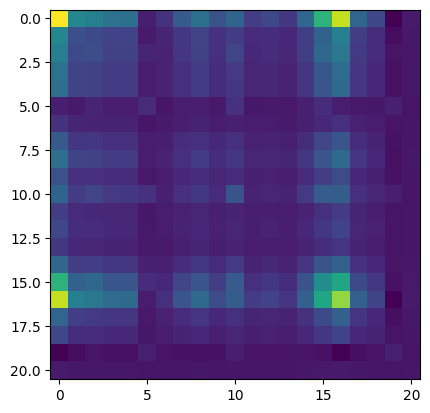

In [213]:
# Plot the covariance matrix in graphical form
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [214]:
num_assets = len(data._tickers)

In [215]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 4.111366353761787e-05*x_0^2 + 3.531671024677999e-0..., 21 variables, 1 constraints, 'Portfolio optimization'>

Create a function to print the results of the optimisers

In [216]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

Sampling Variational Quantum Eigensolver

In [217]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)

Optimal: selection [0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1.], value -0.0076

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1]	-0.0080		0.0029
[1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1]	-0.0071		0.0020
[1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0]	-0.0067		0.0020
[0 1 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1]	-0.0073		0.0020
[1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0]	-0.0067		0.0020
[1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1]	-0.0070		0.0020
[1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0]	-0.0058		0.0020
[0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0]	-0.0073		0.0020
[1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0]	-0.0072		0.0020
[1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1]	-0.0061		0.0020
[1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 1]	-0.0083		0.0020
[1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1]	-0.0068		0.0020
[0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0]	-0.

Quantum Approximate Optimization Algorithm

In [218]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)


Optimal: selection [0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0.], value -0.0077

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0]	-0.0060		0.0020
[0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0]	-0.0065		0.0010
[0 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1]	-0.0063		0.0010
[0 0 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0]	-0.0057		0.0010
[0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 0]	-0.0074		0.0010
[1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 1 0]	-0.0074		0.0010
[1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0]	-0.0065		0.0010
[1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0]	-0.0072		0.0010
[0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1]	-0.0071		0.0010
[1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1]	-0.0060		0.0010
[0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1]	-0.0065		0.0010
[1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0]	-0.0074		0.0010
[1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0]	-0.